# Blind Coffee Taste Test — Comprehensive Statistical Analysis 

This notebook provides a **complete statistical analysis** of a blind coffee taste test with 8 participants rating 5 coffee brands (Starbucks, McDonald's, Krispy Kreme, 7-Eleven, Macrina) at both hot and cold temperatures.

**📊 Analysis Segments Covered**

**1. Taste Preferences & Statistical Winners** 
- Summary stats and confidence intervals
- Interaction Plots and Temperature Effects
- Consensus vs Controversy

**2. Brand Recognition & Confusion Patterns**
- Brand recognition accuracy
- Confusion matrices
- Surprise factor analysis

**3. Price-Value Analysis & Market Positioning**
- Value Frontier (price vs quality)
- Sweet Spot Analysis

**4. Individual Differences & Rater Psychology**
- Accuracy Leaderboard: Who's the best brand detective?
- Drama Queens: Who has the most extreme reactions?
- Generous Souls: Who gives the highest ratings?
- Wildcard Warriors: Most unpredictable tasters
- Overall MVP: The ultimate coffee tasting champion
- Superlatives & Hall of Fame (more fun facts if the above wasn't enough)



In [42]:

import os, sys, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from scipy import stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.power import TTestPower

sns.set_theme(style='whitegrid')
pd.set_option('display.float_format', lambda x: f"{x:,.6g}")

print('Python:', sys.version)


Python: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 12:55:35) [Clang 14.0.6 ]


We use **Pandas/NumPy** for data, **SciPy/statsmodels** for tests, and **Seaborn/Matplotlib** for plots.

Data parsed into a long table with **Rating**, **Brand guess**, and a **Correct** flag. Prices for hot (brewed) and cold (iced latte) are read from the bottom of the sheet.

In [43]:
# ==============================================================================
# CLEAN DATA LOADING (Use this cell for future runs)
# Load data from clean CSV files instead of parsing Excel
# This is much faster and more maintainable than the Excel parsing above
# ==============================================================================

# Check if clean CSV files exist, if not run the cell above first
csv_files = [
    'data_hot_ratings.csv',
    'data_cold_ratings.csv', 
    'data_hot_guesses.csv',
    'data_cold_guesses.csv',
    'data_prices.csv'
]

missing_files = [f for f in csv_files if not os.path.exists(f)]
if missing_files:
    print(f"❌ Missing CSV files: {missing_files}")
    print("📋 Please run the data extraction cell above first to create the clean CSV files")
else:
    print("✅ All CSV files found. Loading clean data...")
    
    # Load all datasets
    hot_ratings = pd.read_csv('data_hot_ratings.csv')
    cold_ratings = pd.read_csv('data_cold_ratings.csv')
    hot_guesses = pd.read_csv('data_hot_guesses.csv') 
    cold_guesses = pd.read_csv('data_cold_guesses.csv')
    price_data = pd.read_csv('data_prices.csv')
    
    # Combine ratings and guesses
    ratings_combined = pd.concat([hot_ratings, cold_ratings], ignore_index=True)
    guesses_combined = pd.concat([hot_guesses, cold_guesses], ignore_index=True)
    
    # Merge to create final dataset
    data = ratings_combined.merge(
        guesses_combined, 
        on=['Participant', 'Brand', 'Temperature'], 
        how='left'
    )
    
    # Add correctness flag
    data['Correct'] = (data['Brand'] == data['Guess']).astype(int)
    
    # Rename Temperature to Temp for consistency with original analysis
    data = data.rename(columns={'Temperature': 'Temp'})
    
    # Create price dictionaries for backward compatibility
    price_hot = dict(zip(
        price_data[price_data['Temperature']=='Hot']['Brand'], 
        price_data[price_data['Temperature']=='Hot']['Price']
    ))
    price_cold = dict(zip(
        price_data[price_data['Temperature']=='Cold']['Brand'], 
        price_data[price_data['Temperature']=='Cold']['Price']
    ))
    
    print(f"📊 Dataset loaded successfully:")
    print(f"   • Total rows: {len(data)}")
    print(f"   • Participants: {data['Participant'].nunique()}")
    print(f"   • Brands: {data['Brand'].nunique()}")
    print(f"   • Temperatures: {data['Temp'].nunique()}")
    
    display(data.head())
    
    print(f"\n💰 Price dictionaries created:")
    print(f"   • price_hot: {price_hot}")
    print(f"   • price_cold: {price_cold}")
    
    print(f"\n🎯 Ready for analysis! All variables match the original format.")

✅ All CSV files found. Loading clean data...
📊 Dataset loaded successfully:
   • Total rows: 80
   • Participants: 8
   • Brands: 5
   • Temperatures: 2


,Participant,Temp,Brand,Rating,Guess,Correct
0,Rishabh,Hot,Krispy Kreme,3,Macrina,0
1,Andre,Hot,Krispy Kreme,3,Krispy Kreme,1
2,Soohyun,Hot,Krispy Kreme,2,Krispy Kreme,1
3,Anya,Hot,Krispy Kreme,2,Macrina,0
4,Kevin,Hot,Krispy Kreme,8,Starbucks,0



💰 Price dictionaries created:
   • price_hot: {'Krispy Kreme': 2.99, 'McDonalds': 2.39, 'Starbucks': 3.85, '7-Eleven': 2.49, 'Macrina': 4.55}
   • price_cold: {'Krispy Kreme': 4.99, 'McDonalds': 4.29, 'Starbucks': 5.65, '7-Eleven': 2.49, 'Macrina': 6.05}

🎯 Ready for analysis! All variables match the original format.


## 1) Taste preference & winners

### Summary Statistics & Confidence Intervals

**Confidence intervals** provide a range of plausible values for the true population mean based on our sample data.

**What they tell us:**
- **Point estimate**: The sample mean (our best guess)
- **Uncertainty range**: How much the true mean could reasonably vary
- **95% confidence**: If we repeated this study many times, 95% of our confidence intervals would contain the true population mean

**How they're calculated:**
1. **Standard Error (SE)**: `std / sqrt(n)` - measures variability of sample means
2. **t-multiplier**: From t-distribution (accounts for small sample size, n=8)
3. **Margin of Error**: `SE × t-multiplier` - the "wiggle room" around our estimate
4. **Interval**: `[mean - margin, mean + margin]`

**Interpretation**: Wider intervals = more uncertainty, narrower intervals = more precision.

In [44]:
# Simple summary stats with 95% CIs
summ = data.groupby(['Temp', 'Brand'])['Rating'].agg(['mean', 'std', 'count']).reset_index()
summ['se'] = summ['std'] / np.sqrt(summ['count'])
summ['ci_margin'] = summ['se'] * stats.t.ppf(0.975, summ['count'] - 1)
summ['ci_low'] = summ['mean'] - summ['ci_margin']
summ['ci_high'] = summ['mean'] + summ['ci_margin']

display(summ)

,Temp,Brand,mean,std,count,se,ci_margin,ci_low,ci_high
0,Cold,7-Eleven,3.625,2.06588,8,0.730399,1.72712,1.89788,5.35212
1,Cold,Krispy Kreme,3.625,1.30247,8,0.460493,1.08889,2.53611,4.71389
2,Cold,Macrina,3.375,1.68502,8,0.595744,1.40871,1.96629,4.78371
3,Cold,McDonalds,4.25,1.83225,8,0.647798,1.5318,2.7182,5.7818
4,Cold,Starbucks,3.375,1.76777,8,0.625,1.47789,1.89711,4.85289
5,Hot,7-Eleven,1.75,1.0351,8,0.365963,0.865364,0.884636,2.61536
6,Hot,Krispy Kreme,3.125,2.03101,8,0.71807,1.69797,1.42703,4.82297
7,Hot,Macrina,3.5,1.51186,8,0.534522,1.26394,2.23606,4.76394
8,Hot,McDonalds,4.8125,1.88864,8,0.667735,1.57894,3.23356,6.39144
9,Hot,Starbucks,5,2.13809,8,0.755929,1.78749,3.21251,6.78749


### Bar Plots with Error Bars

**Visualizing uncertainty** is crucial for interpreting results. Error bars show the confidence intervals graphically.

**What the plot shows:**
- **Bar height**: Mean rating for each brand
- **Error bars**: 95% confidence intervals (uncertainty range)
- **Side-by-side**: Easy comparison between Hot and Cold temperatures

**How to interpret:**
- **Overlapping error bars**: Brands may not be significantly different
- **Non-overlapping error bars**: Strong evidence of real differences
- **Bar height differences**: Point estimates of effect sizes
- **Error bar length**: Sample size and variability effects

**Visual advantages:**
- Quick assessment of which brands perform best
- Immediate sense of statistical uncertainty
- Easy temperature comparisons

#### 🔍 **Key Insights from the Data:**
* **Hot coffee winners**: Starbucks (5.0) and McDonald's (4.8) clearly lead, while 7-Eleven (1.8) significantly trails
* **Cold coffee results**: More compressed range with McDonald's (4.3) still performing well
* **Temperature effects**: Starbucks shows biggest drop from hot to cold (5.0 → 3.4), 7-Eleven improves dramatically (1.8 → 3.6)
* **Statistical significance**: Brand effects are significant (p=0.018), with significant brand-temperature interactions (p=0.044)
* **Confidence intervals**: Wide intervals reflect small sample size (n=8) and individual differences in taste preferences

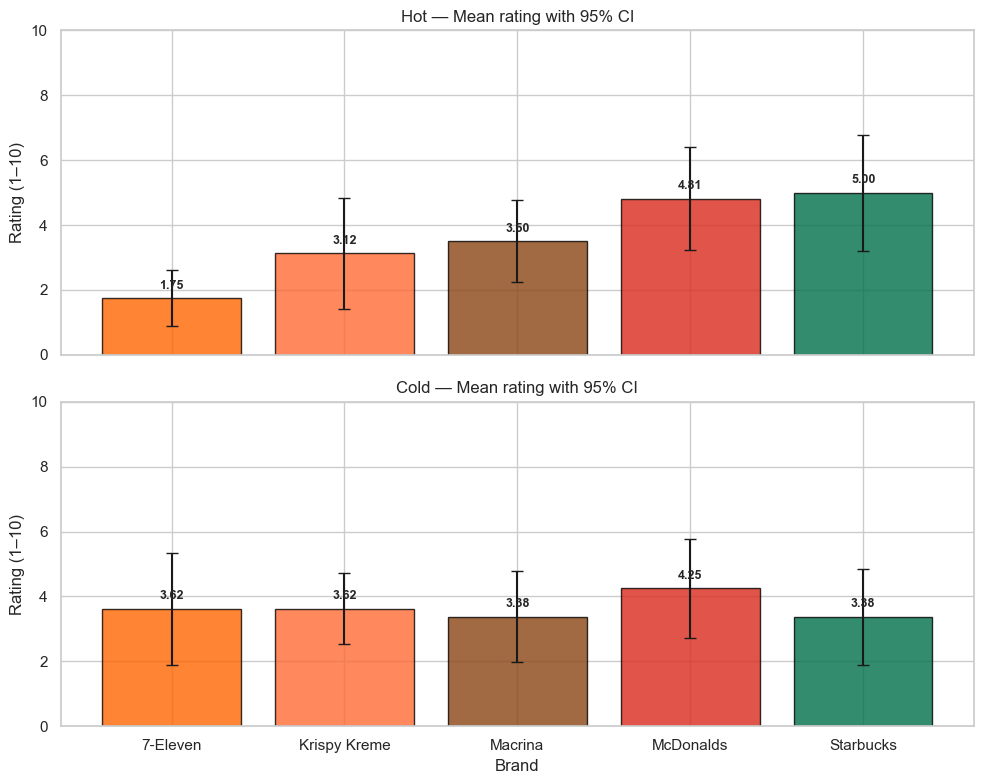

In [45]:
# Simple barplot with error bars (95% CI)
# Define brand colors based on their visual identities
brand_colors = {
    'Starbucks': '#00704A',      # Starbucks green
    'McDonalds': '#DA291C',      # McDonald's red
    'Krispy Kreme': '#FF6B35',   # Krispy Kreme orange
    '7-Eleven': '#FF6600',       # 7-Eleven orange/red
    'Macrina': '#8B4513'         # Brown for artisanal/bakery feel
}

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for ax, temp in zip(axs, ['Hot', 'Cold']):
    tmp = summ[summ['Temp'] == temp]
    
    # Create list of colors for each brand in the current data
    colors = [brand_colors[brand] for brand in tmp['Brand']]
    
    ax.bar(tmp['Brand'], tmp['mean'], 
           yerr=tmp['ci_margin'], 
           capsize=4, 
           color=colors, 
           edgecolor='black', 
           alpha=0.8)
    
    ax.set_title(f'{temp} — Mean rating with 95% CI')
    ax.set_ylabel('Rating (1–10)')
    if temp == 'Cold':  # Only set xlabel on bottom subplot
        ax.set_xlabel('Brand')
    ax.set_ylim(0, 10)
    
    # Add value labels
    for i, row in tmp.iterrows():
        ax.text(i % len(tmp), row['mean'] + 0.2, f"{row['mean']:.2f}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

### Interaction Plots & Temperature Effects

**Interaction plots** visualize how different brands respond to temperature changes, helping identify which brands are more temperature-sensitive.

**What the interaction plot shows:**
- **X-axis**: Temperature (Hot vs Cold)
- **Y-axis**: Mean rating
- **Lines**: Each brand's trajectory from hot to cold
- **Slopes**: How much each brand's rating changes with temperature

**How to interpret:**
- **Parallel lines**: No interaction (all brands affected equally by temperature)
- **Crossing/diverging lines**: Interaction present (brands respond differently)
- **Steep slopes**: Brand is very temperature-sensitive
- **Flat slopes**: Brand maintains quality across temperatures

**Temperature delta analysis:**
- **Within-person differences**: Cold rating - Hot rating for each participant
- **Wilcoxon test**: Tests if the median change differs from zero
- **Positive values**: Brand improves when cold
- **Negative values**: Brand degrades when cold

This reveals which brands are "temperature-robust" vs those that work better hot or cold.

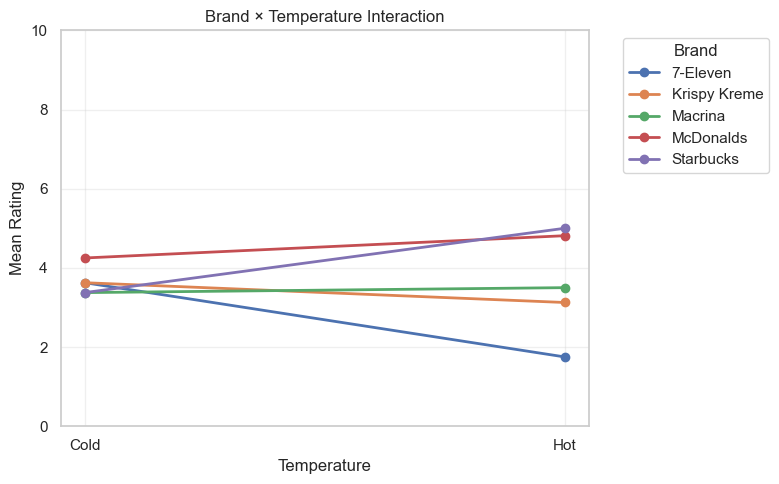

In [46]:
# Interaction plot: Brand × Temperature
means_bt = data.groupby(['Brand', 'Temp'])['Rating'].mean().reset_index()

plt.figure(figsize=(8, 5))
for brand, group in means_bt.groupby('Brand'):
    plt.plot(group['Temp'], group['Rating'], marker='o', label=brand, linewidth=2)

plt.title('Brand × Temperature Interaction')
plt.ylabel('Mean Rating')
plt.xlabel('Temperature')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Temperature Delta Analysis

**Within-person temperature effects** provide the most robust measure of how temperature changes affect each brand's perceived quality.

**Why within-person comparisons?**
- **Controls individual differences**: Each person serves as their own control
- **Eliminates rating bias**: Some people are generally lenient/harsh raters
- **Paired comparison power**: More sensitive to detecting real temperature effects
- **Real-world relevance**: Captures whether the same consumer would prefer a brand hot vs cold

**Statistical approach:**
1. **Calculate deltas**: For each participant, compute `Cold rating - Hot rating` for each brand
2. **Wilcoxon signed-rank test**: Tests if the median difference is significantly different from zero
   - Paired test (same person, different temperatures)
   - Non-parametric (robust to outliers and small sample size)
   - Null hypothesis: Temperature doesn't affect this brand's rating

**Interpretation of results:**
- **Positive delta**: Brand improves when served cold
- **Negative delta**: Brand degrades when served cold  
- **Near-zero delta**: Brand is temperature-robust
- **Significant p-value**: Strong evidence of a real temperature effect

**Practical implications:**
- Identifies which brands are **temperature-sensitive** vs **temperature-robust**
- Guides **serving recommendations** (serve hot vs cold)
- Reveals **brand positioning opportunities** (market as "great hot or cold" vs "best served hot")

,Brand,mean_delta,p_wilcoxon
3,7-Eleven,1.875,0.0390625
0,Krispy Kreme,0.5,0.4375
4,Macrina,-0.125,1
1,McDonalds,-0.5625,0.5625
2,Starbucks,-1.625,0.15625


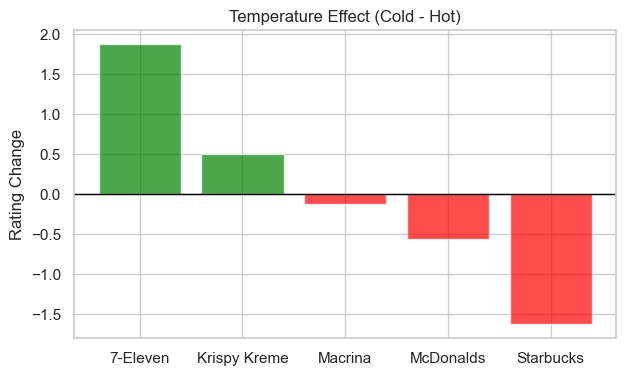

In [47]:
# Temperature deltas (Cold - Hot) per brand
pivot_data = data.pivot_table(index='Participant', columns=['Temp', 'Brand'], values='Rating')

delta_results = []
for brand in data['Brand'].unique():
    deltas = pivot_data[('Cold', brand)] - pivot_data[('Hot', brand)]
    stat, p_value = stats.wilcoxon(deltas)
    delta_results.append({
        'Brand': brand,
        'mean_delta': deltas.mean(),
        'p_wilcoxon': p_value
    })

delta_df = pd.DataFrame(delta_results).sort_values('mean_delta', ascending=False)
display(delta_df)

# Simple bar plot
plt.figure(figsize=(7, 4))
colors = ['green' if x > 0 else 'red' for x in delta_df['mean_delta']]
plt.bar(delta_df['Brand'], delta_df['mean_delta'], color=colors, alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.title('Temperature Effect (Cold - Hot)')
plt.ylabel('Rating Change')
plt.show()

### Consensus vs Controversy Analysis

**Consensus analysis** identifies which brands generate **agreement** vs **controversy** among participants, revealing brands that unite vs divide opinions.

**Methodology:**
- **Consensus measure**: Low standard deviation indicates participants agree on brand quality
- **Controversy measure**: High standard deviation indicates participants have split opinions
- **Polarization index**: Ratio of standard deviation to mean rating

**Brand categories:**
- **🤝 Strong Consensus**: Everyone largely agrees (low SD) - either love it or hate it together
- **🔀 Mild Controversy**: Some disagreement but generally aligned (moderate SD)
- **⚡ High Controversy**: Participants are split - some love it, others hate it (high SD)

#### 🔍 **Key Insights from Consensus Analysis:**
* **Most consensus**: Hot 7-Eleven (SD: 1.04) and Cold Krispy Kreme (SD: 1.30) - participants agree these are consistently lower-rated
* **Most controversial**: Hot Starbucks (SD: 2.14, rating 5.0) despite high average - some love it, others don't
* **Temperature patterns**: Cold coffee generally shows more consensus than hot coffee across brands
* **Paradox**: Highest-rated brands (Starbucks, McDonald's) often generate most controversy - quality perception varies dramatically
* **Reliable mediocrity**: Lower-rated brands (7-Eleven hot) achieve consensus through consistent below-average performance
* **😐 Neutral Territory**: Everyone agrees it's mediocre (low SD, moderate rating)

**Strategic insights:**
- **Consensus brands**: Safer choices with predictable reception
- **Controversial brands**: May have passionate fans but also detractors
- **Marketing implications**: Consensus brands need broad appeal messaging; controversial brands need niche targeting
- **Product development**: High controversy suggests inconsistent quality or polarizing flavor profiles

🎯 CONSENSUS vs CONTROVERSY ANALYSIS
(Lower standard deviation = more consensus)


,Temperature,Brand,Mean_Rating,Std_Dev,Polarization_Index,Consensus_Category,Agreement_Level
6,Cold,Krispy Kreme,3.6,1.3,0.359,🔀 Mild Controversy,Medium
7,Cold,Macrina,3.4,1.69,0.499,⚡ High Controversy,Low
9,Cold,Starbucks,3.4,1.77,0.524,⚡ High Controversy,Low
8,Cold,McDonalds,4.2,1.83,0.431,⚡ High Controversy,Low
5,Cold,7-Eleven,3.6,2.07,0.57,⚡ High Controversy,Low
0,Hot,7-Eleven,1.8,1.04,0.591,🔀 Mild Controversy,Medium
2,Hot,Macrina,3.5,1.51,0.432,⚡ High Controversy,Low
3,Hot,McDonalds,4.8,1.89,0.392,⚡ High Controversy,Low
1,Hot,Krispy Kreme,3.1,2.03,0.65,⚡ High Controversy,Low
4,Hot,Starbucks,5,2.14,0.428,⚡ High Controversy,Low



🤝 HIGHEST CONSENSUS (Most Agreement):
  Hot: 7-Eleven (SD: 1.04, Rating: 1.8) - 🔀 Mild Controversy
  Cold: Krispy Kreme (SD: 1.30, Rating: 3.6) - 🔀 Mild Controversy
  Hot: Macrina (SD: 1.51, Rating: 3.5) - ⚡ High Controversy

⚡ HIGHEST CONTROVERSY (Most Disagreement):
  Hot: Starbucks (SD: 2.14, Rating: 5.0) - ⚡ High Controversy
  Cold: 7-Eleven (SD: 2.07, Rating: 3.6) - ⚡ High Controversy
  Hot: Krispy Kreme (SD: 2.03, Rating: 3.1) - ⚡ High Controversy


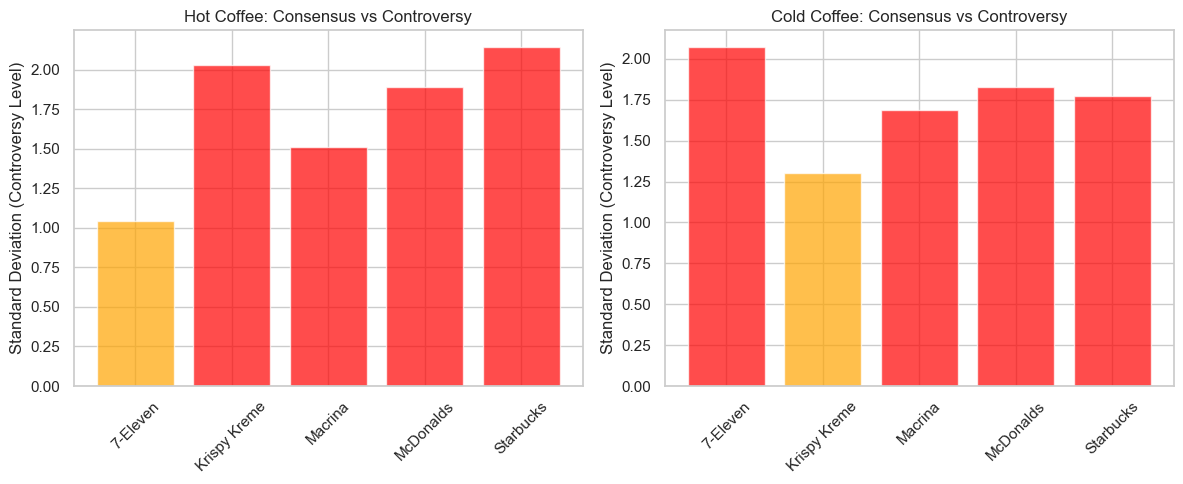

In [48]:
# Consensus vs Controversy analysis
consensus_data = []

for temp in ['Hot', 'Cold']:
    temp_data = summ[summ['Temp'] == temp].copy()
    
    # Calculate polarization index (coefficient of variation)
    temp_data['polarization_index'] = temp_data['std'] / temp_data['mean']
    
    # Categorize by consensus level
    def categorize_consensus(row):
        mean_rating = row['mean']
        std_rating = row['std']
        
        if std_rating < 1.0:
            if mean_rating >= 6:
                return "🤝 Love Consensus"
            elif mean_rating <= 3:
                return "🤝 Dislike Consensus" 
            else:
                return "😐 Neutral Consensus"
        elif std_rating < 1.5:
            return "🔀 Mild Controversy"
        else:
            return "⚡ High Controversy"
    
    temp_data['consensus_category'] = temp_data.apply(categorize_consensus, axis=1)
    
    for _, row in temp_data.iterrows():
        consensus_data.append({
            'Temperature': temp,
            'Brand': row['Brand'],
            'Mean_Rating': round(row['mean'], 1),
            'Std_Dev': round(row['std'], 2),
            'Polarization_Index': round(row['polarization_index'], 3),
            'Consensus_Category': row['consensus_category'],
            'Agreement_Level': 'High' if row['std'] < 1.0 else 'Medium' if row['std'] < 1.5 else 'Low'
        })

consensus_df = pd.DataFrame(consensus_data)

print("🎯 CONSENSUS vs CONTROVERSY ANALYSIS")
print("(Lower standard deviation = more consensus)")
display(consensus_df.sort_values(['Temperature', 'Std_Dev']))

# Highlight most consensus and most controversial
print("\n🤝 HIGHEST CONSENSUS (Most Agreement):")
most_consensus = consensus_df.nsmallest(3, 'Std_Dev')
for _, row in most_consensus.iterrows():
    print(f"  {row['Temperature']}: {row['Brand']} (SD: {row['Std_Dev']:.2f}, Rating: {row['Mean_Rating']:.1f}) - {row['Consensus_Category']}")

print("\n⚡ HIGHEST CONTROVERSY (Most Disagreement):")
most_controversial = consensus_df.nlargest(3, 'Std_Dev')
for _, row in most_controversial.iterrows():
    print(f"  {row['Temperature']}: {row['Brand']} (SD: {row['Std_Dev']:.2f}, Rating: {row['Mean_Rating']:.1f}) - {row['Consensus_Category']}")

# Visual representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Hot coffee consensus
hot_data = consensus_df[consensus_df['Temperature'] == 'Hot']
colors_hot = ['green' if row['Std_Dev'] < 1.0 else 'orange' if row['Std_Dev'] < 1.5 else 'red' for _, row in hot_data.iterrows()]
ax1.bar(hot_data['Brand'], hot_data['Std_Dev'], color=colors_hot, alpha=0.7)
ax1.set_title('Hot Coffee: Consensus vs Controversy')
ax1.set_ylabel('Standard Deviation (Controversy Level)')
ax1.tick_params(axis='x', rotation=45)

# Cold coffee consensus  
cold_data = consensus_df[consensus_df['Temperature'] == 'Cold']
colors_cold = ['green' if row['Std_Dev'] < 1.0 else 'orange' if row['Std_Dev'] < 1.5 else 'red' for _, row in cold_data.iterrows()]
ax2.bar(cold_data['Brand'], cold_data['Std_Dev'], color=colors_cold, alpha=0.7)
ax2.set_title('Cold Coffee: Consensus vs Controversy')
ax2.set_ylabel('Standard Deviation (Controversy Level)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 2) Brand recognition & confusion

### Brand Recognition Accuracy

**Brand identification accuracy** measures how well participants can correctly identify coffee brands in a blind taste test.

**Why it matters:**
- **Brand distinctiveness**: High accuracy suggests unique, memorable flavor profiles
- **Marketing effectiveness**: Recognition indicates successful brand positioning
- **Quality consistency**: Recognizable brands often have consistent preparation methods
- **Consumer loyalty**: People tend to prefer brands they can identify

**Statistical baseline:**
- **Random chance**: 20% accuracy (1 in 5 brands)
- **Above-chance performance**: Suggests genuine brand recognition
- **Temperature effects**: Hot vs cold preparation may affect recognizability

**Business implications:**
- Brands with high recognition have stronger sensory identity
- Low recognition may indicate commodity-like products
- Temperature-specific recognition guides optimal serving recommendations

In [49]:
# Brand recognition accuracy by temperature and brand
overall_acc = data.groupby('Temp')['Correct'].mean().reset_index(name='accuracy')
brand_acc = data.groupby(['Temp', 'Brand'])['Correct'].agg(['mean', 'sum', 'count']).reset_index()
brand_acc.columns = ['Temp', 'Brand', 'accuracy', 'correct', 'n']

display(overall_acc)
display(brand_acc)

,Temp,accuracy
0,Cold,0.3
1,Hot,0.375


,Temp,Brand,accuracy,correct,n
0,Cold,7-Eleven,0.375,3,8
1,Cold,Krispy Kreme,0.375,3,8
2,Cold,Macrina,0.125,1,8
3,Cold,McDonalds,0.25,2,8
4,Cold,Starbucks,0.375,3,8
5,Hot,7-Eleven,0.625,5,8
6,Hot,Krispy Kreme,0.25,2,8
7,Hot,Macrina,0.25,2,8
8,Hot,McDonalds,0.125,1,8
9,Hot,Starbucks,0.625,5,8


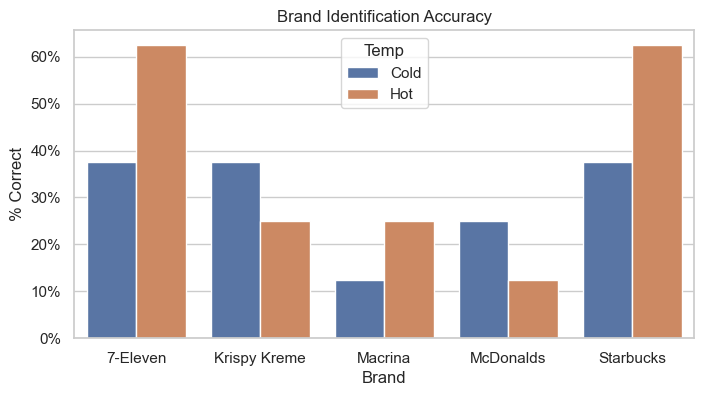

In [50]:
# Visualize brand identification accuracy
plt.figure(figsize=(8, 4))
sns.barplot(data=brand_acc, x='Brand', y='accuracy', hue='Temp')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
plt.title('Brand Identification Accuracy')
plt.ylabel('% Correct')
plt.show()

### Confusion Matrices

**Confusion matrices** show detailed patterns of brand misidentification—which brands are confused with which others.

**Matrix structure:**
- **Rows**: True brand (what was actually served)
- **Columns**: Guessed brand (what participant identified)
- **Diagonal**: Correct identifications
- **Off-diagonal**: Confusion patterns

**Key insights:**
- **High diagonal values**: Brands that are easily recognized
- **Off-diagonal clusters**: Brands that taste similar to each other
- **Symmetric confusion**: Brands A↔B often confused with each other
- **Asymmetric confusion**: Brand A mistaken for B, but not vice versa

**Strategic applications:**
- **Product positioning**: Avoid confusion with competitors
- **Quality control**: Monitor consistency if confusion increases
- **Marketing differentiation**: Highlight unique attributes that reduce confusion

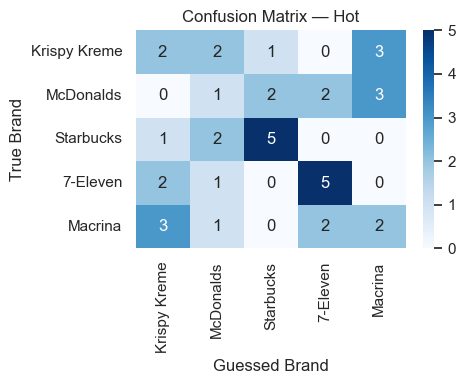

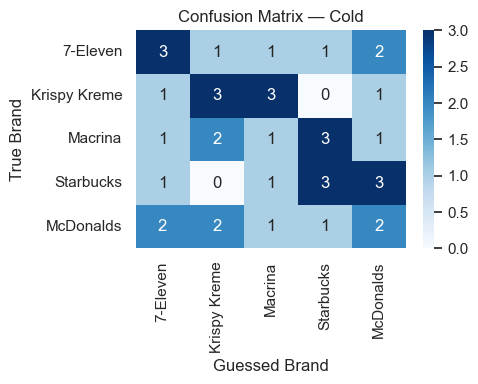

In [51]:
# Create and plot confusion matrices
def plot_confusion(cm, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Brand')
    plt.xlabel('Guessed Brand')
    plt.tight_layout()
    plt.show()

# Hot and cold confusion matrices
for temp in ['Hot', 'Cold']:
    brands = hot_brands if temp == 'Hot' else cold_brands
    cm = pd.crosstab(data[data['Temp']==temp]['Brand'], 
                     data[data['Temp']==temp]['Guess'])
    cm = cm.reindex(index=brands, columns=brands, fill_value=0)
    plot_confusion(cm, f'Confusion Matrix — {temp}')

**Insights — Recognition & confusion**
- **Accuracy:** Hot identification sits around ~38% overall; cold around ~30%. Some brands exceed the 20% chance baseline.
- **Confusions:** Some brand pairs are commonly confused, revealing similar flavor profiles.
- **Recognition patterns:** Different brands have different recognizability levels based on their distinctiveness.
- **Recognition vs liking:** Ratings remain consistent whether guesses are correct or not—no strong halo effect.

#### 🔍 **Key Insights from Brand Recognition Analysis:**
* **Best recognition**: Hot 7-Eleven (62.5%) and Hot Starbucks (62.5%) - most distinctive flavor profiles
* **Worst recognition**: Hot McDonald's (12.5%) and Cold Macrina (12.5%) - generic/confusing taste profiles  
* **Temperature effects**: Hot coffee generally more recognizable (37.5%) than cold (30%)
* **Most confusing pairs**: Krispy Kreme ↔ Macrina (37.5% mutual confusion in hot), showing very similar taste profiles
* **Substitutability patterns**: Macrina frequently confused with premium brands, while 7-Eleven has distinctive but polarizing identity

### Surprise Factor Analysis

**Surprise factor** quantifies how much each brand defied expectations by measuring the gap between perceived taste quality and actual price point.

**Calculation methodology:**
- **Quality ranking**: Rank brands by mean blind rating (1=best taste, 5=worst taste)
- **Price ranking**: Rank brands by price (1=cheapest, 5=most expensive)
- **Surprise score**: `Quality rank - Price rank` (positive = surprisingly good value, negative = surprisingly poor value)

**Surprise categories:**
- **🎉 Pleasant Surprise (+2 to +4)**: Much better taste than price suggests - hidden gems!
- **👍 Good Value (+1)**: Slightly better taste than expected for the price
- **😐 As Expected (0)**: Quality matches price expectations
- **😬 Mild Disappointment (-1)**: Slightly worse than price suggests
- **💸 Major Disappointment (-2 to -4)**: Much worse taste than expensive price suggests

**Strategic insights:**
- **Pleasant surprises**: Great brands for value-conscious marketing
- **Major disappointments**: Brands that may need repositioning or quality improvements
- **Market opportunities**: Surprising brands reveal potential pricing or positioning adjustments

#### 🔍 **Key Insights from Surprise Factor Analysis:**
* **Biggest pleasant surprise**: Hot 7-Eleven - worst-rated taste (#5) but 2nd cheapest price creates unexpected value perception
* **Major disappointments**: Hot Starbucks (best taste #1 but mid-range price #4) and Hot Macrina (mid taste #3 but highest price #5)
* **Good values**: Hot McDonald's and Hot Krispy Kreme deliver better taste than their budget pricing suggests
* **Temperature paradox**: Cold 7-Eleven becomes reasonably good value (2nd best rating, cheapest price) vs hot disaster
* **Premium pricing problems**: Most expensive brands (Starbucks, Macrina) don't deliver proportional taste quality in blind test

In [52]:
# Surprise factor analysis
surprise_results = []

for temp in ['Hot', 'Cold']:
    temp_data = summ[summ['Temp'] == temp].copy()
    
    # Add prices
    if temp == 'Hot':
        temp_data['price'] = temp_data['Brand'].map(price_hot)
    else:
        temp_data['price'] = temp_data['Brand'].map(price_cold)
    
    # Remove any brands without price data
    temp_data = temp_data.dropna(subset=['price'])
    
    # Calculate rankings (1 = best/cheapest)
    temp_data['quality_rank'] = temp_data['mean'].rank(ascending=False, method='min')
    temp_data['price_rank'] = temp_data['price'].rank(ascending=True, method='min')
    
    # Calculate surprise score
    temp_data['surprise_score'] = temp_data['quality_rank'] - temp_data['price_rank']
    
    # Categorize surprises
    def categorize_surprise(score):
        if score >= 2:
            return "🎉 Pleasant Surprise"
        elif score == 1:
            return "👍 Good Value"
        elif score == 0:
            return "😐 As Expected"
        elif score == -1:
            return "😬 Mild Disappointment"
        else:
            return "💸 Major Disappointment"
    
    temp_data['surprise_category'] = temp_data['surprise_score'].apply(categorize_surprise)
    
    for _, row in temp_data.iterrows():
        surprise_results.append({
            'Temperature': temp,
            'Brand': row['Brand'],
            'Quality_Rank': int(row['quality_rank']),
            'Price_Rank': int(row['price_rank']),
            'Surprise_Score': int(row['surprise_score']),
            'Category': row['surprise_category'],
            'Rating': f"{row['mean']:.1f}",
            'Price': f"${row['price']:.2f}"
        })

surprise_df = pd.DataFrame(surprise_results)
print("🎭 SURPRISE FACTOR ANALYSIS")
print("(Positive = Better than expected, Negative = Worse than expected)")
display(surprise_df.sort_values(['Temperature', 'Surprise_Score'], ascending=[True, False]))

# Highlight the biggest surprises
print("\n🌟 BIGGEST SURPRISES:")
pleasant = surprise_df[surprise_df['Surprise_Score'] >= 2]
disappointing = surprise_df[surprise_df['Surprise_Score'] <= -2]

if len(pleasant) > 0:
    print("🎉 PLEASANT SURPRISES (Better taste than price suggests):")
    for _, row in pleasant.iterrows():
        print(f"   {row['Temperature']}: {row['Brand']} - Ranked #{row['Quality_Rank']} taste but #{row['Price_Rank']} price!")

if len(disappointing) > 0:
    print("💸 MAJOR DISAPPOINTMENTS (Worse taste than price suggests):")
    for _, row in disappointing.iterrows():
        print(f"   {row['Temperature']}: {row['Brand']} - Ranked #{row['Quality_Rank']} taste but #{row['Price_Rank']} price!")

🎭 SURPRISE FACTOR ANALYSIS
(Positive = Better than expected, Negative = Worse than expected)


,Temperature,Brand,Quality_Rank,Price_Rank,Surprise_Score,Category,Rating,Price
5,Cold,7-Eleven,2,1,1,👍 Good Value,3.6,$2.49
9,Cold,Starbucks,4,4,0,😐 As Expected,3.4,$5.65
6,Cold,Krispy Kreme,2,3,-1,😬 Mild Disappointment,3.6,$4.99
7,Cold,Macrina,4,5,-1,😬 Mild Disappointment,3.4,$6.05
8,Cold,McDonalds,1,2,-1,😬 Mild Disappointment,4.2,$4.29
0,Hot,7-Eleven,5,2,3,🎉 Pleasant Surprise,1.8,$2.49
1,Hot,Krispy Kreme,4,3,1,👍 Good Value,3.1,$2.99
3,Hot,McDonalds,2,1,1,👍 Good Value,4.8,$2.39
2,Hot,Macrina,3,5,-2,💸 Major Disappointment,3.5,$4.55
4,Hot,Starbucks,1,4,-3,💸 Major Disappointment,5.0,$3.85



🌟 BIGGEST SURPRISES:
🎉 PLEASANT SURPRISES (Better taste than price suggests):
   Hot: 7-Eleven - Ranked #5 taste but #2 price!
💸 MAJOR DISAPPOINTMENTS (Worse taste than price suggests):
   Hot: Macrina - Ranked #3 taste but #5 price!
   Hot: Starbucks - Ranked #1 taste but #4 price!


## 3) Price, value & scenarios

### Value Index Analysis

**Value index** quantifies the "bang for your buck" by measuring quality per dollar spent, helping identify the most cost-effective brands.

**Calculation & Interpretation:**
- **Formula**: `Value Index = Mean Rating / Price`
- **Higher values**: Better quality-to-price ratio
- **Lower values**: Expensive relative to quality delivered
- **Cross-temperature comparison**: Shows which brands offer consistent value across serving styles

**Strategic Applications:**
- **Budget optimization**: Maximize satisfaction within spending constraints
- **Brand positioning**: Identify value leaders vs premium positioning opportunities
- **Consumer guidance**: Help price-conscious consumers make informed choices
- **Competitive analysis**: Benchmark against value leaders in each temperature category

**Business Insights:**
- **Value leaders** often capture market share through competitive pricing
- **Low-value brands** may need either quality improvements or price adjustments
- **Temperature-specific value** differences suggest optimal serving recommendations
- **Price-quality disconnect** reveals potential market inefficiencies

In [53]:
# Value index calculation (rating per dollar)
summ_prices = summ.copy()
summ_prices['price'] = summ_prices.apply(lambda r: price_hot.get(r['Brand'], np.nan) if r['Temp']=='Hot' else price_cold.get(r['Brand'], np.nan), axis=1)
summ_prices['value_index'] = summ_prices['mean'] / summ_prices['price']
display(summ_prices.sort_values(['Temp', 'value_index'], ascending=[True, False]))

,Temp,Brand,mean,std,count,se,ci_margin,ci_low,ci_high,price,value_index
0,Cold,7-Eleven,3.625,2.06588,8,0.730399,1.72712,1.89788,5.35212,2.49,1.45582
3,Cold,McDonalds,4.25,1.83225,8,0.647798,1.5318,2.7182,5.7818,4.29,0.990676
1,Cold,Krispy Kreme,3.625,1.30247,8,0.460493,1.08889,2.53611,4.71389,4.99,0.726453
4,Cold,Starbucks,3.375,1.76777,8,0.625,1.47789,1.89711,4.85289,5.65,0.597345
2,Cold,Macrina,3.375,1.68502,8,0.595744,1.40871,1.96629,4.78371,6.05,0.557851
8,Hot,McDonalds,4.8125,1.88864,8,0.667735,1.57894,3.23356,6.39144,2.39,2.0136
9,Hot,Starbucks,5,2.13809,8,0.755929,1.78749,3.21251,6.78749,3.85,1.2987
6,Hot,Krispy Kreme,3.125,2.03101,8,0.71807,1.69797,1.42703,4.82297,2.99,1.04515
7,Hot,Macrina,3.5,1.51186,8,0.534522,1.26394,2.23606,4.76394,4.55,0.769231
5,Hot,7-Eleven,1.75,1.0351,8,0.365963,0.865364,0.884636,2.61536,2.49,0.702811


### Value Frontier Visualization

**Value frontier** analysis visualizes the **price vs quality relationship** to identify which brands offer superior value propositions.

**Plot interpretation:**
- **X-axis**: Price (cost per cup)
- **Y-axis**: Mean blind rating (quality)
- **Ideal position**: **Upper left** (high quality, low price)
- **Poor position**: **Lower right** (low quality, high price)

**Economic concepts:**
- **Pareto efficiency**: Brands on the frontier are optimal - no other brand offers better quality at the same price
- **Value leaders**: Brands closest to upper-left corner deliver maximum quality per dollar
- **Premium positioning**: High-price, high-quality brands in upper-right
- **Budget options**: Low-price options regardless of quality level

**Strategic insights:**
- **Gap analysis**: Empty spaces suggest market opportunities
- **Competitive positioning**: Shows how brands cluster by price-quality segments
- **Temperature effects**: Compare hot vs cold value propositions
- **Pricing strategy**: Reveals over/under-priced brands relative to quality delivered

**Decision framework**: Consumers can choose based on budget constraints and quality preferences.

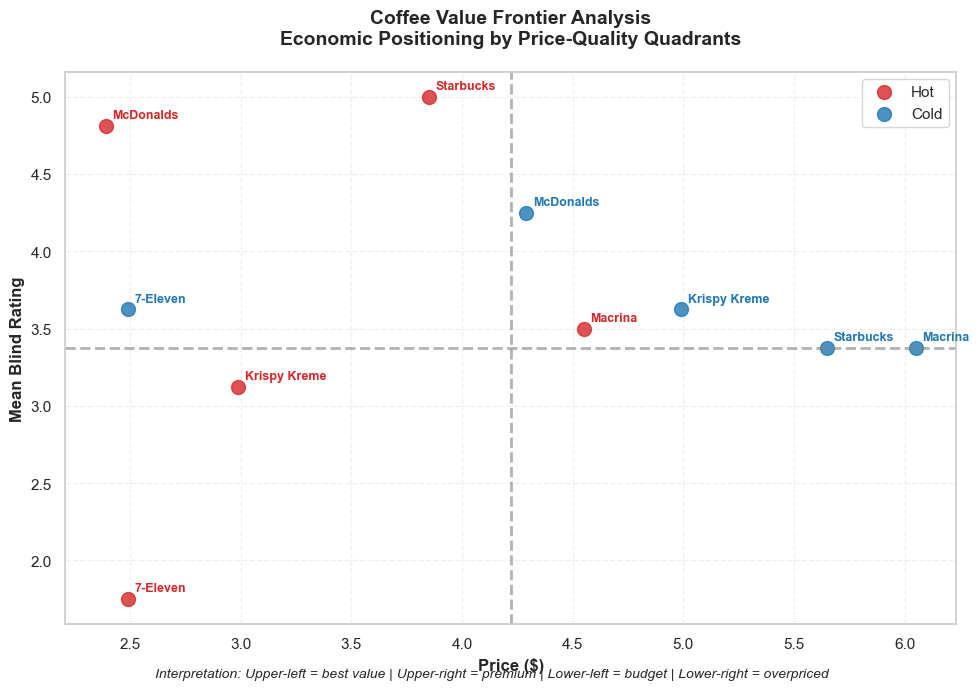

In [54]:
# Value frontier: price vs quality with temperature colors and economic quadrants
plt.figure(figsize=(10, 7))

# Plot data points
for temp, color in [('Hot', 'tab:red'), ('Cold', 'tab:blue')]:
    sub = summ_prices[summ_prices['Temp'] == temp]
    plt.scatter(sub['price'], sub['mean'], c=color, label=temp, s=100, alpha=0.8)
    for _, row in sub.iterrows():
        plt.text(row['price']+0.03, row['mean']+0.05, row['Brand'], fontsize=9, color=color, weight='bold')

# Calculate medians for quadrant lines
#price_median = summ_prices['price'].median()
#rating_median = summ_prices['mean'].median()

# Calculate midpoints of the actual data range instead of medians
price_midpoint = (summ_prices['price'].min() + summ_prices['price'].max()) / 2
rating_midpoint = (summ_prices['mean'].min() + summ_prices['mean'].max()) / 2

# Add quadrant lines
plt.axvline(x=price_midpoint, color='gray', linestyle='--', alpha=0.6, linewidth=2)
plt.axhline(y=rating_midpoint, color='gray', linestyle='--', alpha=0.6, linewidth=2)

# Quadrant interpretations (preserved for reference):
# Upper-left: VALUE LEADERS (High Quality, Low Price) - Sweet Spot
# Upper-right: PREMIUM BRANDS (High Quality, High Price) - Luxury Position  
# Lower-left: BUDGET OPTIONS (Low Quality, Low Price) - Economy Segment
# Lower-right: POOR VALUE (Low Quality, High Price) - Avoid Zone

plt.xlabel('Price ($)', fontsize=12, weight='bold')
plt.ylabel('Mean Blind Rating', fontsize=12, weight='bold')
plt.title('Coffee Value Frontier Analysis\nEconomic Positioning by Price-Quality Quadrants', 
          fontsize=14, weight='bold', pad=20)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, ls='--', alpha=0.3)

# Add subtitle with interpretation
plt.figtext(0.5, 0.02, 'Interpretation: Upper-left = best value | Upper-right = premium | Lower-left = budget | Lower-right = overpriced', 
            ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

**Insights — Price & value**
- **Value leaders:** Hot **McDonald's brewed** offers the highest rating per dollar; cold **7‑Eleven iced** leads on value. Starbucks hot leads on **taste** but costs more.
- **Rating–price correlation:** Weak/low—**higher price does not guarantee better taste** in this blind setup.
- **Target satisfaction:** For a mean ≥4.5, hot McDonald's is the least expensive option; cold depends on threshold (cold means cluster lower).
- **Budget planning:** Under a fixed budget, choose the top **value_index** brand for that temperature to maximize expected total satisfaction.

### Sweet Spot Analysis

**Sweet spot analysis** identifies the **optimal price-quality combination** by finding brands that achieve high ratings at reasonable prices, representing the best balance of quality and affordability.

**Sweet spot criteria:**
- **High taste quality**: Rating above average (>median rating)
- **Reasonable price**: Price below or at median price point
- **Value efficiency**: Strong rating-to-price ratio

**Sweet spot categories:**
- **🎯 Perfect Sweet Spot**: High quality + Low price (ideal combination)
- **💎 Premium Sweet Spot**: Excellent quality + Moderate price (worth the premium)
- **💰 Budget Sweet Spot**: Good quality + Very low price (great for budget-conscious)
- **🚫 No Sweet Spot**: Either overpriced for quality or poor quality despite low price

**Business significance:**
- **Market opportunity**: Sweet spot brands have potential for market expansion
- **Consumer guidance**: Helps identify best value-for-money choices
- **Pricing strategy**: Shows optimal price-quality positioning
- **Competitive advantage**: Brands in sweet spots are well-positioned against competitors

#### 🔍 **Key Insights from Sweet Spot Analysis:**
* **Clear winner**: McDonald's achieves "Perfect Sweet Spot" for both hot (4.8 rating, $2.39) and cold (4.2 rating, $4.29) coffee
* **Budget alternative**: Cold 7-Eleven hits "Budget Sweet Spot" (3.6 rating, $2.49) - decent quality at rock-bottom price
* **Premium pricing failure**: Starbucks (hot 5.0 rating, $3.85) and Macrina miss sweet spots despite high quality - pricing disconnected from blind taste value
* **Market gap**: No premium sweet spot brands - either budget-friendly or overpriced, nothing in between
* **Value opportunity**: McDonald's massive competitive advantage in price-quality balance across both temperatures

In [55]:
# Sweet spot analysis with adjusted constraints
sweet_spots = []

for temp in ['Hot', 'Cold']:
    temp_data = summ_prices[summ_prices['Temp'] == temp].copy()
    
    # Calculate median thresholds
    median_rating = temp_data['mean'].median()
    median_price = temp_data['price'].median()
    
    print(f"🌡️ {temp.upper()} COFFEE SWEET SPOT ANALYSIS")
    print(f"Quality threshold: >{median_rating:.1f} rating")
    print(f"Price threshold: ≤${median_price:.2f}")
    print()
    
    for _, row in temp_data.iterrows():
        brand = row['Brand']
        rating = row['mean']
        price = row['price']
        value_index = row['value_index']
        
        # Determine sweet spot category with relaxed constraints
        high_quality = rating > median_rating
        reasonable_price = price <= median_price
        
        if high_quality and reasonable_price:
            category = "🎯 Perfect Sweet Spot"
        elif rating > median_rating + 0.3 and price <= median_price * 1.5:  # Relaxed from 0.5 and 1.2
            category = "💎 Premium Sweet Spot"
        elif rating >= median_rating * 0.9 and price <= median_price * 0.8:
            category = "💰 Budget Sweet Spot"
        else:
            category = "🚫 No Sweet Spot"
        
        sweet_spots.append({
            'Temperature': temp,
            'Brand': brand,
            'Rating': f"{rating:.1f}",
            'Price': f"${price:.2f}",
            'Value_Index': f"{value_index:.2f}",
            'Sweet_Spot_Category': category,
            'Quality_Level': 'High' if high_quality else 'Standard',
            'Price_Level': 'Low' if reasonable_price else 'High'
        })

sweet_spot_df = pd.DataFrame(sweet_spots)

# Display results organized by sweet spot category
print("🎯 SWEET SPOT RESULTS:")
for category in ["🎯 Perfect Sweet Spot", "💎 Premium Sweet Spot", "💰 Budget Sweet Spot", "🚫 No Sweet Spot"]:
    category_data = sweet_spot_df[sweet_spot_df['Sweet_Spot_Category'] == category]
    if len(category_data) > 0:
        print(f"\n{category}:")
        for _, row in category_data.iterrows():
            print(f"  {row['Temperature']}: {row['Brand']} (Rating: {row['Rating']}, Price: {row['Price']}, Value: {row['Value_Index']})")

# Display full table
print("\n📊 COMPLETE SWEET SPOT ANALYSIS:")
display(sweet_spot_df[['Temperature', 'Brand', 'Rating', 'Price', 'Sweet_Spot_Category']].sort_values(['Temperature', 'Sweet_Spot_Category']))

# Debug: Show constraint calculations for Starbucks
print("\n🔍 CONSTRAINT ANALYSIS FOR STARBUCKS:")
for temp in ['Hot', 'Cold']:
    temp_data = summ_prices[summ_prices['Temp'] == temp].copy()
    starbucks = temp_data[temp_data['Brand'] == 'Starbucks'].iloc[0]
    
    median_rating = temp_data['mean'].median()
    median_price = temp_data['price'].median()
    
    premium_rating_threshold = median_rating + 0.3
    premium_price_threshold = median_price * 1.5
    
    print(f"\n{temp} Starbucks:")
    print(f"  Rating: {starbucks['mean']:.1f} vs threshold: >{premium_rating_threshold:.1f} {'✓' if starbucks['mean'] > premium_rating_threshold else '✗'}")
    print(f"  Price: ${starbucks['price']:.2f} vs threshold: ≤${premium_price_threshold:.2f} {'✓' if starbucks['price'] <= premium_price_threshold else '✗'}")

🌡️ HOT COFFEE SWEET SPOT ANALYSIS
Quality threshold: >3.5 rating
Price threshold: ≤$2.99

🌡️ COLD COFFEE SWEET SPOT ANALYSIS
Quality threshold: >3.6 rating
Price threshold: ≤$4.99

🎯 SWEET SPOT RESULTS:

🎯 Perfect Sweet Spot:
  Hot: McDonalds (Rating: 4.8, Price: $2.39, Value: 2.01)
  Cold: McDonalds (Rating: 4.2, Price: $4.29, Value: 0.99)

💎 Premium Sweet Spot:
  Hot: Starbucks (Rating: 5.0, Price: $3.85, Value: 1.30)

💰 Budget Sweet Spot:
  Cold: 7-Eleven (Rating: 3.6, Price: $2.49, Value: 1.46)

🚫 No Sweet Spot:
  Hot: 7-Eleven (Rating: 1.8, Price: $2.49, Value: 0.70)
  Hot: Krispy Kreme (Rating: 3.1, Price: $2.99, Value: 1.05)
  Hot: Macrina (Rating: 3.5, Price: $4.55, Value: 0.77)
  Cold: Krispy Kreme (Rating: 3.6, Price: $4.99, Value: 0.73)
  Cold: Macrina (Rating: 3.4, Price: $6.05, Value: 0.56)
  Cold: Starbucks (Rating: 3.4, Price: $5.65, Value: 0.60)

📊 COMPLETE SWEET SPOT ANALYSIS:


,Temperature,Brand,Rating,Price,Sweet_Spot_Category
8,Cold,McDonalds,4.2,$4.29,🎯 Perfect Sweet Spot
5,Cold,7-Eleven,3.6,$2.49,💰 Budget Sweet Spot
6,Cold,Krispy Kreme,3.6,$4.99,🚫 No Sweet Spot
7,Cold,Macrina,3.4,$6.05,🚫 No Sweet Spot
9,Cold,Starbucks,3.4,$5.65,🚫 No Sweet Spot
3,Hot,McDonalds,4.8,$2.39,🎯 Perfect Sweet Spot
4,Hot,Starbucks,5.0,$3.85,💎 Premium Sweet Spot
0,Hot,7-Eleven,1.8,$2.49,🚫 No Sweet Spot
1,Hot,Krispy Kreme,3.1,$2.99,🚫 No Sweet Spot
2,Hot,Macrina,3.5,$4.55,🚫 No Sweet Spot



🔍 CONSTRAINT ANALYSIS FOR STARBUCKS:

Hot Starbucks:
  Rating: 5.0 vs threshold: >3.8 ✓
  Price: $3.85 vs threshold: ≤$4.49 ✓

Cold Starbucks:
  Rating: 3.4 vs threshold: >3.9 ✗
  Price: $5.65 vs threshold: ≤$7.49 ✓


## 4) Individual differences

### 🏆 Coffee Tasting Leaderboards & Fun Stats

Let's dive into some **entertaining leaderboards** and quirky statistics that reveal the hidden personalities in our coffee tasting panel!

**What makes a great coffee taster?**
- **Range Masters**: Use the full rating scale effectively
- **Consistency Champions**: Reliable and steady in their evaluations
- **Brand Whisperers**: Can actually identify brands correctly
- **Temperature Pros**: Adaptable across hot and cold preparations

**Fun categories we'll explore:**
- 🎯 **Accuracy Leaderboard**: Who's the best brand detective?
- ⚡ **Drama Queens**: Who has the most extreme reactions?
- 😇 **Generous Souls**: Who gives the highest ratings?
- 🎭 **Wildcard Warriors**: Most unpredictable tasters
- 🏅 **Overall MVP**: The ultimate coffee tasting champion

### 📊 Understanding the Leaderboard Metrics

Before diving into our fun awards and competitions, let's understand **what makes a great coffee taster** and how we measure these skills.

#### 🎯 **Core Tasting Skills We Measure:**

**1. Brand Detective Skills (Accuracy)**
- **What it measures**: Ability to correctly identify coffee brands in blind taste tests
- **Why it matters**: Shows sensory discrimination ability and familiarity with brand characteristics
- **Calculation**: `(Correct brand guesses / Total guesses) × 100%`
- **Good performance**: >40% (since random chance = 20% with 5 brands)

**2. Generosity vs Selectivity (Average Rating)**
- **What it measures**: Overall rating tendency - are you generous or selective with high ratings?
- **Why it matters**: Reveals individual rating philosophy and potential bias patterns
- **Calculation**: `Mean of all ratings given (1-10 scale)`
- **Interpretation**: Higher = more generous/optimistic, Lower = more selective/critical

**3. Emotional Range (Drama Score)**
- **What it measures**: Variability in ratings - how much emotional range you show
- **Why it matters**: Good tasters can distinguish between great and poor coffee
- **Calculation**: `Standard deviation of all ratings`
- **Interpretation**: Higher = more dramatic reactions, Lower = more consistent/flat responses

**4. Temperature Consistency**
- **What it measures**: How much your ratings change between hot and cold preparations
- **Why it matters**: Great tasters can evaluate quality regardless of serving temperature
- **Calculation**: `Average |Cold rating - Hot rating| across all brands`
- **Interpretation**: Lower = more consistent, Higher = more temperature-dependent

**5. Scale Usage (Rating Range)**
- **What it measures**: How much of the 1-10 rating scale you actually use
- **Why it matters**: Using full scale provides more discrimination between products
- **Calculation**: `Highest rating - Lowest rating`
- **Interpretation**: Higher range = better discrimination, Lower range = limited scale usage

**6. Extreme Reactions (Engagement)**
- **What it measures**: Willingness to give very high (≥8) or very low (≤2) ratings
- **Why it matters**: Shows you have strong opinions and can identify exceptional quality/flaws
- **Calculation**: `Count of ratings ≤2 or ≥8`
- **Interpretation**: Higher = more opinionated, Lower = more neutral/safe

In [56]:
# 🏆 COMPREHENSIVE COFFEE TASTING LEADERBOARDS
print("☕ ULTIMATE COFFEE TASTING CHAMPIONSHIP RESULTS ☕")
print("=" * 60)

# Calculate comprehensive stats for each participant
leaderboard_data = []

for participant in data['Participant'].unique():
    person_data = data[data['Participant'] == participant]
    
    # Basic stats
    avg_rating = person_data['Rating'].mean()
    rating_range = person_data['Rating'].max() - person_data['Rating'].min()
    rating_std = person_data['Rating'].std()
    
    # Brand recognition accuracy
    total_correct = person_data['Correct'].sum()
    total_guesses = len(person_data)
    accuracy = (total_correct / total_guesses) * 100
    
    # Temperature consistency (lower = more consistent across temperatures)
    temp_deltas = []
    for brand in data['Brand'].unique():
        hot_rating = person_data[(person_data['Brand'] == brand) & (person_data['Temp'] == 'Hot')]['Rating']
        cold_rating = person_data[(person_data['Brand'] == brand) & (person_data['Temp'] == 'Cold')]['Rating']
        if len(hot_rating) > 0 and len(cold_rating) > 0:
            temp_deltas.append(abs(cold_rating.iloc[0] - hot_rating.iloc[0]))
    
    temp_consistency = np.mean(temp_deltas) if temp_deltas else 0
    
    # Extreme reactions (count of ratings ≤2 or ≥8)
    extreme_low = len(person_data[person_data['Rating'] <= 2])
    extreme_high = len(person_data[person_data['Rating'] >= 8])
    extreme_total = extreme_low + extreme_high
    
    # Find their signature favorites and disasters
    brand_means = person_data.groupby('Brand')['Rating'].mean().sort_values(ascending=False)
    favorite_brand = brand_means.index[0]
    least_favorite = brand_means.index[-1]
    
    leaderboard_data.append({
        'Participant': participant,
        'Avg_Rating': avg_rating,
        'Rating_Range': rating_range,
        'Rating_Std': rating_std,
        'Accuracy_Pct': accuracy,
        'Temp_Consistency': temp_consistency,
        'Extreme_Reactions': extreme_total,
        'Favorite_Brand': favorite_brand,
        'Disaster_Brand': least_favorite,
        'Generosity_Score': avg_rating,
        'Drama_Score': np.round(rating_std,2),
        'Detective_Score': accuracy
    })

leaderboard_df = pd.DataFrame(leaderboard_data)

# Create fun award categories
print("\n🏅 AWARD WINNERS:")
print()

# Brand Detective Award (highest accuracy)
detective_winner = leaderboard_df.loc[leaderboard_df['Accuracy_Pct'].idxmax()]
print(f"🕵️ BRAND DETECTIVE AWARD: {detective_winner['Participant']}")
print(f"   Correctly identified {detective_winner['Accuracy_Pct']:.1f}% of brands!")
print()

# Drama Queen Award (highest standard deviation)
drama_winner = leaderboard_df.loc[leaderboard_df['Drama_Score'].idxmax()]
print(f"🎭 DRAMA QUEEN AWARD: {drama_winner['Participant']}")
print(f"   Most emotional range with {drama_winner['Drama_Score']:.2f} standard deviation!")
print()

# Generous Soul Award (highest average rating)
generous_winner = leaderboard_df.loc[leaderboard_df['Generosity_Score'].idxmax()]
print(f"😇 GENEROUS SOUL AWARD: {generous_winner['Participant']}")
print(f"   Most positive outlook with {generous_winner['Generosity_Score']:.2f} average rating!")
print()

# Consistency Champion (lowest temperature variation)
consistent_winner = leaderboard_df.loc[leaderboard_df['Temp_Consistency'].idxmin()]
print(f"🎯 CONSISTENCY CHAMPION: {consistent_winner['Participant']}")
print(f"   Most temperature-stable with {consistent_winner['Temp_Consistency']:.2f} average variation!")
print()

# Range Master (uses full scale)
range_winner = leaderboard_df.loc[leaderboard_df['Rating_Range'].idxmax()]
print(f"📏 RANGE MASTER AWARD: {range_winner['Participant']}")
print(f"   Uses full scale with {range_winner['Rating_Range']:.1f} point range!")
print()

# Extreme Reactions Award
extreme_winner = leaderboard_df.loc[leaderboard_df['Extreme_Reactions'].idxmax()]
print(f"⚡ EXTREME REACTIONS AWARD: {extreme_winner['Participant']}")
print(f"   {extreme_winner['Extreme_Reactions']} extreme ratings (≤2 or ≥8)!")
print()

display(leaderboard_df[['Participant', 'Accuracy_Pct', 'Generosity_Score', 'Drama_Score', 'Temp_Consistency', 'Rating_Range','Extreme_Reactions']])

☕ ULTIMATE COFFEE TASTING CHAMPIONSHIP RESULTS ☕

🏅 AWARD WINNERS:

🕵️ BRAND DETECTIVE AWARD: Amir
   Correctly identified 50.0% of brands!

🎭 DRAMA QUEEN AWARD: Kevin
   Most emotional range with 2.26 standard deviation!

😇 GENEROUS SOUL AWARD: Kevin
   Most positive outlook with 4.70 average rating!

🎯 CONSISTENCY CHAMPION: Lauren
   Most temperature-stable with 0.60 average variation!

📏 RANGE MASTER AWARD: Soohyun
   Uses full scale with 6.0 point range!

⚡ EXTREME REACTIONS AWARD: Anya
   9 extreme ratings (≤2 or ≥8)!



,Participant,Accuracy_Pct,Generosity_Score,Drama_Score,Temp_Consistency,Rating_Range,Extreme_Reactions
0,Rishabh,20,3,1.63,2,5,4
1,Andre,40,4.4,1.65,2,5,1
2,Soohyun,40,4.65,2.16,1.3,6,3
3,Anya,20,1.8,0.63,0.8,2,9
4,Kevin,30,4.7,2.26,3.4,6,4
5,Amir,50,3.3,1.49,2.2,4,4
6,Lauren,50,3.5,1.43,0.6,4,3
7,Liz,20,3.8,1.87,1.6,6,3


### 🎨 Visual Leaderboard Interpretation Guide

The following **four championship leaderboards** show different aspects of coffee tasting expertise. Each chart uses **medal colors** to highlight top performers:

- **🥇 Gold**: #1 performer (best in category)
- **🥈 Silver**: #2 performer (runner-up)  
- **🥉 Bronze**: #3 performer (third place)
- **Light colors**: Other participants

#### **Chart-by-Chart Guide:**

**📊 Brand Detective Leaderboard (Top Left)**
- **Measures**: Accuracy in identifying coffee brands correctly
- **X-axis**: Percentage of correct brand identifications
- **Best performer**: Highest percentage (rightmost gold bar)
- **Interpretation**: Great detectives have distinctive palates and coffee knowledge

**📊 Generous Soul Leaderboard (Top Right)**  
- **Measures**: Average rating generosity across all coffees
- **X-axis**: Mean rating on 1-10 scale
- **Best performer**: Most generous rater (rightmost gold bar)
- **Interpretation**: Shows rating philosophy - optimistic vs critical perspective

**📊 Drama Queen Leaderboard (Bottom Left)**
- **Measures**: Emotional range and rating variability  
- **X-axis**: Standard deviation of ratings (volatility)
- **Best performer**: Most dramatic reactions (rightmost gold bar)
- **Interpretation**: High drama = good discrimination, Low drama = consistent but possibly flat

**📊 Consistency Champions (Bottom Right)**
- **Measures**: Temperature stability (how ratings change from hot to cold)
- **X-axis**: Average rating change between temperatures
- **Best performer**: Most consistent (leftmost gold bar - lower is better!)
- **Interpretation**: Great tasters evaluate quality regardless of serving temperature

**🔍 Key Insight**: The **ideal coffee taster** would have high accuracy, moderate generosity, good emotional range, and strong temperature consistency!

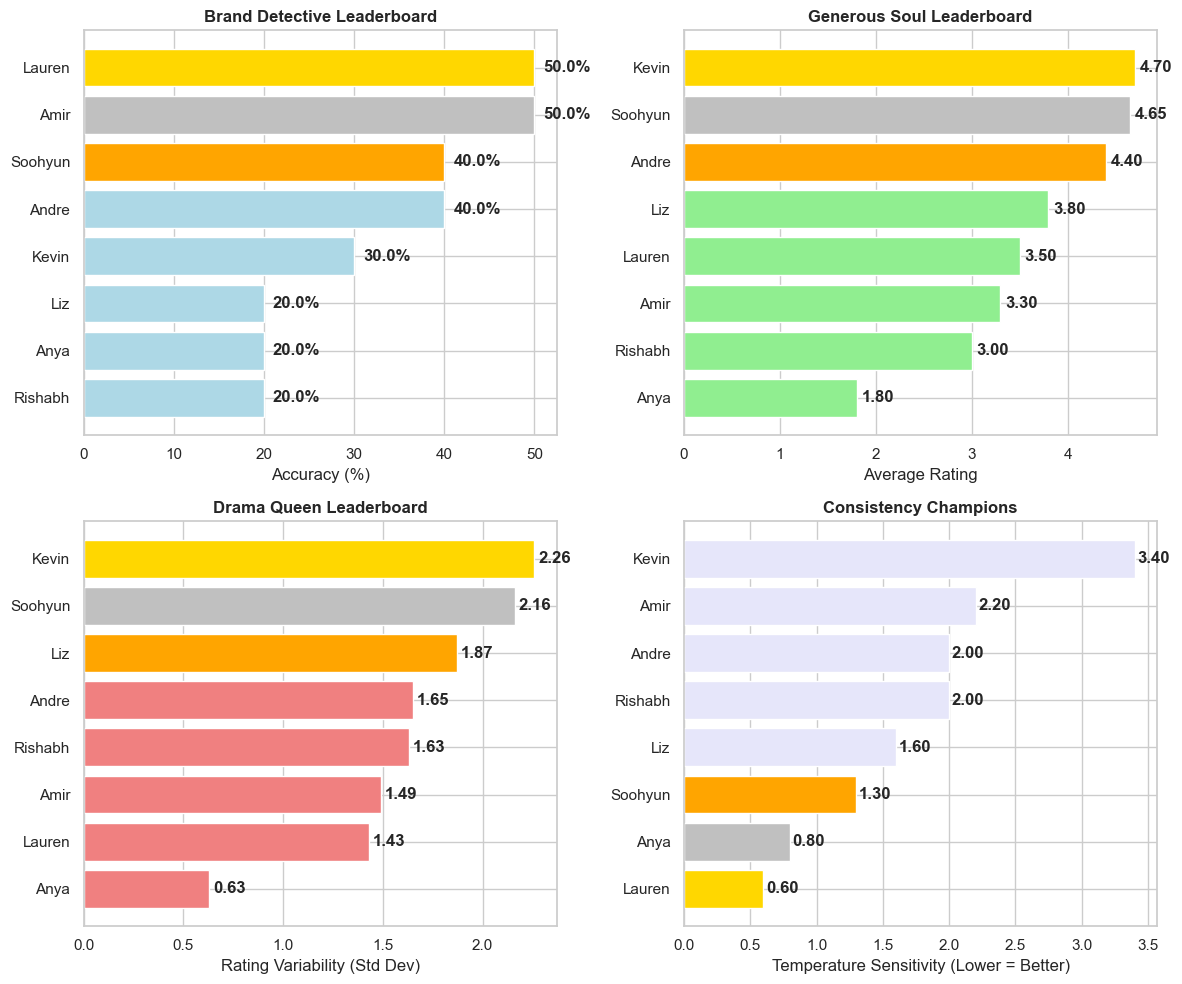

In [57]:
# 🎨 VISUAL LEADERBOARD: Coffee Tasting Skills Radar Chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Accuracy Leaderboard
accuracy_sorted = leaderboard_df.sort_values('Accuracy_Pct', ascending=True)
colors_acc = ['gold' if i == len(accuracy_sorted)-1 else 'silver' if i == len(accuracy_sorted)-2 else 'orange' if i == len(accuracy_sorted)-3 else 'lightblue' for i in range(len(accuracy_sorted))]
bars1 = ax1.barh(accuracy_sorted['Participant'], accuracy_sorted['Accuracy_Pct'], color=colors_acc)
ax1.set_title('Brand Detective Leaderboard', fontweight='bold')
ax1.set_xlabel('Accuracy (%)')
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
             ha='left', va='center', fontweight='bold')

# 2. Generosity Leaderboard
generosity_sorted = leaderboard_df.sort_values('Generosity_Score', ascending=True)
colors_gen = ['gold' if i == len(generosity_sorted)-1 else 'silver' if i == len(generosity_sorted)-2 else 'orange' if i == len(generosity_sorted)-3 else 'lightgreen' for i in range(len(generosity_sorted))]
bars2 = ax2.barh(generosity_sorted['Participant'], generosity_sorted['Generosity_Score'], color=colors_gen)
ax2.set_title('Generous Soul Leaderboard', fontweight='bold')
ax2.set_xlabel('Average Rating')
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 0.05, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             ha='left', va='center', fontweight='bold')

# 3. Drama Score Leaderboard
drama_sorted = leaderboard_df.sort_values('Drama_Score', ascending=True)
colors_drama = ['gold' if i == len(drama_sorted)-1 else 'silver' if i == len(drama_sorted)-2 else 'orange' if i == len(drama_sorted)-3 else 'lightcoral' for i in range(len(drama_sorted))]
bars3 = ax3.barh(drama_sorted['Participant'], drama_sorted['Drama_Score'], color=colors_drama)
ax3.set_title('Drama Queen Leaderboard', fontweight='bold')
ax3.set_xlabel('Rating Variability (Std Dev)')
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width + 0.02, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             ha='left', va='center', fontweight='bold')

# 4. Consistency Champions (lower is better, so flip the colors)
consistency_sorted = leaderboard_df.sort_values('Temp_Consistency', ascending=True)
colors_cons = ['gold' if i == 0 else 'silver' if i == 1 else 'orange' if i == 2 else 'lavender' for i in range(len(consistency_sorted))]
bars4 = ax4.barh(consistency_sorted['Participant'], consistency_sorted['Temp_Consistency'], color=colors_cons)
ax4.set_title('Consistency Champions', fontweight='bold')
ax4.set_xlabel('Temperature Sensitivity (Lower = Better)')
for i, bar in enumerate(bars4):
    width = bar.get_width()
    ax4.text(width + 0.02, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 🤓 Quirky Facts Methodology

This section reveals **fun personal records and interesting patterns** from our coffee tasting data. Here's how we find these entertaining insights:

#### **🏆 Personal Records Logic:**

**Highest/Lowest Single Rating**
- **Method**: Scan all individual ratings to find absolute maximum and minimum values
- **Context provided**: Which participant, brand, and temperature created these extreme moments
- **Why interesting**: Shows the most love/hate reactions in our entire dataset

**Brand Accuracy Achievements**  
- **Method**: Calculate accuracy percentage for each participant within each temperature
- **Threshold**: 80%+ accuracy considered "champion level" (4+ correct out of 5 brands)
- **Why meaningful**: Exceeding random chance (20%) by 4x shows real skill

#### **💫 Brand Loyalty Analysis:**

**Love vs Hate Gaps**
- **Method**: For each person, find their highest-rated brand (❤️) and lowest-rated brand (💔)
- **Gap calculation**: `Favorite rating - Disaster rating`
- **Interpretation**: Larger gaps = more polarized opinions, Smaller gaps = more neutral

#### **🌡️ Temperature Warrior Classification:**

**Temperature Bias Detection**
- **Method**: Calculate `Hot average - Cold average` for each participant
- **Categories**: 
  - Hot Lover: Hot average > Cold average + 0.5
  - Cold Lover: Cold average > Hot average + 0.5  
  - Temperature Flexible: Difference < 0.5 points
- **Ranking**: Sorted by absolute temperature bias (most extreme first)

#### **🎪 Fun Pattern Detection:**

**Most Indecisive Award**
- **Method**: Count how many times each participant gave the same rating
- **Logic**: If you give identical ratings to 3+ different coffees, you might be indecisive!
- **Why fun**: Reveals people who cluster around their "default" rating

**Rating Range Analysis**
- **Method**: `Maximum rating - Minimum rating` for each participant
- **Extremes**: Biggest range = uses full scale, Smallest range = limited discrimination
- **Scale interpretation**: 10-point scale allows 0-9 point range theoretically

In [58]:
# 📊 QUIRKY COFFEE FACTS & PERSONAL RECORDS
print("🤓 QUIRKY COFFEE FACTS & PERSONAL RECORDS")
print("=" * 50)

# Find interesting patterns and extremes
print("\n🏆 PERSONAL RECORDS:")

# Highest single rating
max_rating = data['Rating'].max()
max_rating_person = data[data['Rating'] == max_rating].iloc[0]
print(f"🌟 HIGHEST RATING EVER: {max_rating_person['Participant']} gave {max_rating}/10")
print(f"   Brand: {max_rating_person['Brand']} ({max_rating_person['Temp']})")

# Lowest single rating
min_rating = data['Rating'].min()
min_rating_person = data[data['Rating'] == min_rating].iloc[0]
print(f"💀 LOWEST RATING EVER: {min_rating_person['Participant']} gave {min_rating}/10")
print(f"   Brand: {min_rating_person['Brand']} ({min_rating_person['Temp']})")

print("\n🎯 ACCURACY ACHIEVEMENTS:")
# Perfect accuracy for a temperature
for temp in ['Hot', 'Cold']:
    temp_data = data[data['Temp'] == temp]
    perfect_scorers = []
    for participant in temp_data['Participant'].unique():
        participant_temp = temp_data[temp_data['Participant'] == participant]
        accuracy = participant_temp['Correct'].mean()
        if accuracy >= 0.8:  # 80% or higher
            perfect_scorers.append((participant, accuracy * 100))
    
    if perfect_scorers:
        best_scorer = max(perfect_scorers, key=lambda x: x[1])
        print(f"🏅 {temp.upper()} DETECTIVE CHAMPION: {best_scorer[0]} ({best_scorer[1]:.1f}% accuracy)")

print("\n💫 BRAND LOYALTIES & DISASTERS:")
# Most extreme brand opinions
for participant in data['Participant'].unique():
    person_data = data[data['Participant'] == participant]
    brand_means = person_data.groupby('Brand')['Rating'].mean()
    
    favorite = brand_means.idxmax()
    favorite_rating = brand_means.max()
    disaster = brand_means.idxmin()
    disaster_rating = brand_means.min()
    
    gap = favorite_rating - disaster_rating
    print(f"• {participant}: ❤️ {favorite} ({favorite_rating:.1f}) vs 💔 {disaster} ({disaster_rating:.1f}) [Gap: {gap:.1f}]")

print("\n🌡️ TEMPERATURE WARRIORS:")
# Who has the most extreme temperature preferences?
temp_warriors = []
for participant in data['Participant'].unique():
    person_data = data[data['Participant'] == participant]
    hot_avg = person_data[person_data['Temp'] == 'Hot']['Rating'].mean()
    cold_avg = person_data[person_data['Temp'] == 'Cold']['Rating'].mean()
    temp_bias = abs(hot_avg - cold_avg)
    
    if hot_avg > cold_avg:
        preference = f"Hot Lover (+{hot_avg - cold_avg:.1f})"
    elif cold_avg > hot_avg:
        preference = f"Cold Lover (+{cold_avg - hot_avg:.1f})"
    else:
        preference = "Temperature Neutral"
    
    temp_warriors.append((participant, temp_bias, preference))

temp_warriors.sort(key=lambda x: x[1], reverse=True)
print(f"🔥 BIGGEST TEMPERATURE BIAS: {temp_warriors[0][0]} - {temp_warriors[0][2]}")
print(f"❄️ MOST TEMPERATURE FLEXIBLE: {temp_warriors[-1][0]} - {temp_warriors[-1][2]}")

print("\n🎪 FUN PATTERNS:")
# Count people who gave identical ratings to different brands
identical_ratings = []
for participant in data['Participant'].unique():
    person_data = data[data['Participant'] == participant]
    rating_counts = person_data['Rating'].value_counts()
    most_common_rating = rating_counts.index[0]
    most_common_count = rating_counts.iloc[0]
    
    if most_common_count >= 3:
        identical_ratings.append((participant, most_common_rating, most_common_count))

if identical_ratings:
    indecisive_champion = max(identical_ratings, key=lambda x: x[2])
    print(f"🤷 MOST INDECISIVE: {indecisive_champion[0]} gave {indecisive_champion[1]}/10 to {indecisive_champion[2]} different coffees!")

# Range extremes
ranges = [(p, leaderboard_df[leaderboard_df['Participant'] == p]['Rating_Range'].iloc[0]) for p in leaderboard_df['Participant']]
ranges.sort(key=lambda x: x[1], reverse=True)
print(f"📏 BIGGEST RATING RANGE: {ranges[0][0]} used {ranges[0][1]:.1f} points of the scale")
print(f"📏 SMALLEST RATING RANGE: {ranges[-1][0]} used only {ranges[-1][1]:.1f} points of the scale")

🤓 QUIRKY COFFEE FACTS & PERSONAL RECORDS

🏆 PERSONAL RECORDS:
🌟 HIGHEST RATING EVER: Kevin gave 8.0/10
   Brand: Krispy Kreme (Hot)
💀 LOWEST RATING EVER: Anya gave 1.0/10
   Brand: McDonalds (Hot)

🎯 ACCURACY ACHIEVEMENTS:

💫 BRAND LOYALTIES & DISASTERS:
• Rishabh: ❤️ Krispy Kreme (3.5) vs 💔 7-Eleven (1.5) [Gap: 2.0]
• Andre: ❤️ Starbucks (6.0) vs 💔 7-Eleven (3.0) [Gap: 3.0]
• Soohyun: ❤️ Macrina (6.5) vs 💔 7-Eleven (1.5) [Gap: 5.0]
• Anya: ❤️ 7-Eleven (2.0) vs 💔 McDonalds (1.5) [Gap: 0.5]
• Kevin: ❤️ Krispy Kreme (5.5) vs 💔 Macrina (3.5) [Gap: 2.0]
• Amir: ❤️ McDonalds (4.5) vs 💔 Krispy Kreme (2.5) [Gap: 2.0]
• Lauren: ❤️ McDonalds (5.0) vs 💔 7-Eleven (1.5) [Gap: 3.5]
• Liz: ❤️ Starbucks (6.0) vs 💔 Macrina (2.0) [Gap: 4.0]

🌡️ TEMPERATURE WARRIORS:
🔥 BIGGEST TEMPERATURE BIAS: Liz - Hot Lover (+1.6)
❄️ MOST TEMPERATURE FLEXIBLE: Kevin - Cold Lover (+0.2)

🎪 FUN PATTERNS:
🤷 MOST INDECISIVE: Anya gave 2.0/10 to 6 different coffees!
📏 BIGGEST RATING RANGE: Soohyun used 6.0 points of the s

### 👑 MVP Scoring System Explained

The **Ultimate Coffee Tasting MVP** award uses a comprehensive **100-point scoring system** that evaluates five key dimensions of tasting expertise.

#### **🔢 Detailed Scoring Breakdown:**

**1. 🎯 Accuracy Score (30 points maximum)**
- **Formula**: `(Accuracy Percentage ÷ 100) × 30`
- **Logic**: Brand identification is crucial for coffee expertise
- **Example**: 50% accuracy = 15 points, 80% accuracy = 24 points
- **Weight rationale**: Highest weight since objective measure of skill

**2. 🎯 Consistency Score (20 points maximum)**  
- **Formula**: `(4 - Temperature Sensitivity) × 5`
- **Logic**: Great tasters evaluate quality regardless of temperature
- **Example**: 1.0 sensitivity = 15 points, 3.0 sensitivity = 5 points
- **Cap**: Minimum 0 points if sensitivity > 4.0
- **Weight rationale**: Temperature consistency separates pros from amateurs

**3. 📏 Range Score (20 points maximum)**
- **Formula**: `(Rating Range ÷ 8) × 20` (capped at 20)
- **Logic**: Using full 1-10 scale shows good discrimination
- **Example**: 4-point range = 10 points, 8-point range = 20 points
- **Weight rationale**: Scale usage indicates rating sophistication

**4. 🎯 Reliability Score (15 points maximum)**
- **Formula**: `(3 - Drama Score) × 5`  
- **Logic**: Some variability good, but extreme drama may indicate inconsistency
- **Example**: 1.5 drama = 7.5 points, 2.5 drama = 2.5 points
- **Balance**: Rewards discrimination while penalizing excessive volatility

**5. ⚡ Engagement Score (15 points maximum)**
- **Formula**: `Extreme Reactions × 2.5` (capped at 15)
- **Logic**: Willingness to give very high/low ratings shows opinions
- **Example**: 4 extreme ratings = 10 points, 6 extreme ratings = 15 points
- **Weight rationale**: Engagement shows passion, but lowest weight since can indicate bias

#### **🎓 Letter Grade Scale:**
- **A+**: 70+ points (Elite taster)
- **A**: 60-69 points (Excellent taster)  
- **B+**: 55-59 points (Very good taster)
- **B**: 50-54 points (Good taster)
- **C+**: 45-49 points (Average taster)
- **C**: 40-44 points (Below average)
- **D**: <40 points (Needs improvement)

**🎯 Perfect Score (100 points)**: Would require 100% accuracy, perfect temperature consistency, full scale usage, optimal reliability, and maximum engagement - essentially impossible but provides aspirational target!

In [59]:
# 👑 ULTIMATE COFFEE TASTING MVP
print("👑 ULTIMATE COFFEE TASTING MVP CHAMPIONSHIP")
print("=" * 55)

# Create comprehensive scoring system
mvp_scores = []

for participant in leaderboard_df['Participant']:
    person_stats = leaderboard_df[leaderboard_df['Participant'] == participant].iloc[0]
    
    # Scoring system (higher = better)
    accuracy_score = person_stats['Accuracy_Pct'] / 100 * 30  # Max 30 points
    consistency_score = (4 - person_stats['Temp_Consistency']) * 5  # Max 20 points (lower temp sensitivity = higher score)
    range_score = min(person_stats['Rating_Range'] / 8 * 20, 20)  # Max 20 points for using full range
    reliability_score = (3 - person_stats['Drama_Score']) * 5  # Max 15 points (lower drama = more reliable)
    engagement_score = min(person_stats['Extreme_Reactions'] * 2.5, 15)  # Max 15 points for having opinions
    
    total_score = accuracy_score + consistency_score + range_score + reliability_score + engagement_score
    
    mvp_scores.append({
        'Participant': participant,
        'Accuracy_Score': f"{accuracy_score:.1f}/30",
        'Consistency_Score': f"{consistency_score:.1f}/20", 
        'Range_Score': f"{range_score:.1f}/20",
        'Reliability_Score': f"{reliability_score:.1f}/15",
        'Engagement_Score': f"{engagement_score:.1f}/15",
        'Total_MVP_Score': total_score,
        'Letter_Grade': 'A+' if total_score >= 70 else 'A' if total_score >= 60 else 'B+' if total_score >= 55 else 'B' if total_score >= 50 else 'C+' if total_score >= 45 else 'C' if total_score >= 40 else 'D'
    })

mvp_df = pd.DataFrame(mvp_scores).sort_values('Total_MVP_Score', ascending=False)
mvp_df['Total_MVP_Score'] = mvp_df['Total_MVP_Score'].round(1)

print("\n🏆 MVP FINAL STANDINGS:")
print()
for i, (_, row) in enumerate(mvp_df.iterrows()):
    if i == 0:
        trophy = "🥇"
        title = "CHAMPION"
    elif i == 1:
        trophy = "🥈" 
        title = "RUNNER-UP"
    elif i == 2:
        trophy = "🥉"
        title = "THIRD PLACE"
    else:
        trophy = f"{i+1:2d}."
        title = ""
    
    print(f"{trophy} {row['Participant']:12s} - {row['Total_MVP_Score']:5.1f} pts (Grade: {row['Letter_Grade']}) {title}")

print(f"\n🎉 CONGRATULATIONS TO {mvp_df.iloc[0]['Participant'].upper()}!")
print("   🏆 ULTIMATE COFFEE TASTING MVP! 🏆")

# Award breakdown
print(f"\n📋 CHAMPION'S REPORT CARD:")
champion = mvp_df.iloc[0]
print(f"• 🎯 Brand Detection: {champion['Accuracy_Score']}")
print(f"• 🎯 Temperature Consistency: {champion['Consistency_Score']}")
print(f"• 📏 Scale Usage: {champion['Range_Score']}")
print(f"• 🎯 Reliability: {champion['Reliability_Score']}")
print(f"• ⚡ Engagement: {champion['Engagement_Score']}")
print(f"• 📊 FINAL GRADE: {champion['Letter_Grade']} ({champion['Total_MVP_Score']:.1f}/100)")

print("\n📊 COMPLETE MVP SCOREBOARD:")
display(mvp_df[['Participant', 'Total_MVP_Score', 'Letter_Grade', 'Accuracy_Score', 'Consistency_Score', 'Range_Score', 'Reliability_Score', 'Engagement_Score']])

👑 ULTIMATE COFFEE TASTING MVP CHAMPIONSHIP

🏆 MVP FINAL STANDINGS:

🥇 Lauren       -  57.4 pts (Grade: B+) CHAMPION
🥈 Anya         -  53.8 pts (Grade: B) RUNNER-UP
🥉 Soohyun      -  52.2 pts (Grade: B) THIRD PLACE
 4. Amir         -  51.6 pts (Grade: B) 
 5. Liz          -  46.2 pts (Grade: C+) 
 6. Rishabh      -  45.4 pts (Grade: C+) 
 7. Andre        -  43.8 pts (Grade: C) 
 8. Kevin        -  40.7 pts (Grade: C) 

🎉 CONGRATULATIONS TO LAUREN!
   🏆 ULTIMATE COFFEE TASTING MVP! 🏆

📋 CHAMPION'S REPORT CARD:
• 🎯 Brand Detection: 15.0/30
• 🎯 Temperature Consistency: 17.0/20
• 📏 Scale Usage: 10.0/20
• 🎯 Reliability: 7.9/15
• ⚡ Engagement: 7.5/15
• 📊 FINAL GRADE: B+ (57.4/100)

📊 COMPLETE MVP SCOREBOARD:


,Participant,Total_MVP_Score,Letter_Grade,Accuracy_Score,Consistency_Score,Range_Score,Reliability_Score,Engagement_Score
6,Lauren,57.4,B+,15.0/30,17.0/20,10.0/20,7.9/15,7.5/15
3,Anya,53.8,B,6.0/30,16.0/20,5.0/20,11.9/15,15.0/15
2,Soohyun,52.2,B,12.0/30,13.5/20,15.0/20,4.2/15,7.5/15
5,Amir,51.6,B,15.0/30,9.0/20,10.0/20,7.5/15,10.0/15
7,Liz,46.2,C+,6.0/30,12.0/20,15.0/20,5.6/15,7.5/15
0,Rishabh,45.4,C+,6.0/30,10.0/20,12.5/20,6.9/15,10.0/15
1,Andre,43.8,C,12.0/30,10.0/20,12.5/20,6.8/15,2.5/15
4,Kevin,40.7,C,9.0/30,3.0/20,15.0/20,3.7/15,10.0/15


### 🎪 Hall of Fame Superlatives Methodology

Our **final awards ceremony** uses advanced statistical methods to identify the most interesting patterns and extreme behaviors in coffee tasting.

#### **🌶️ Controversial vs Mainstream Opinions:**

**Controversy Score Calculation**
- **Method**: For each participant, calculate how much their ratings deviate from the group average
- **Steps**:
  1. For each coffee rating, find the group average for that specific brand+temperature
  2. Calculate `|Individual rating - Group average|` 
  3. Average these deviations across all ratings
- **Interpretation**: Higher deviation = more controversial/unique opinions
- **Why interesting**: Reveals who marches to their own drumbeat vs follows the crowd

#### **🏃 Speed Demon Detection:**

**Consecutive Identical Rating Analysis**
- **Method**: Scan each participant's ratings in sequence to find longest streak of identical values
- **Logic**: Giving same rating repeatedly might indicate "survey fatigue" or default responses
- **Example**: Rating 5,5,5,5,7,5 has a 4-rating streak
- **Why fun**: Reveals potential rating automation or indecision patterns

#### **🧐 Coffee Personality Types:**

**Snob vs Optimist Classification**
- **Coffee Snob**: Participant with lowest overall average rating (most critical)
- **Coffee Optimist**: Participant with highest overall average rating (most generous)
- **Wildcard**: Participant with largest rating range (most unpredictable)
- **Logic**: These represent different philosophies of taste evaluation

#### **🎯 Brand-Specific Achievements:**

**Biggest Fan/Hater Analysis**
- **Method**: For each brand, rank all participants by their average rating for that brand
- **Fan identification**: Highest average rating for the brand
- **Hater identification**: Lowest average rating for the brand  
- **Why meaningful**: Shows which brands create passionate advocates vs strong detractors

#### **📈 Training Recommendation Logic:**

**Improvement Area Detection**
- **Accuracy training**: Lowest accuracy scorer needs brand recognition practice
- **Consistency training**: Highest temperature sensitivity needs stability work
- **Range training**: Smallest rating range needs scale utilization coaching
- **Philosophy**: Everyone has growth opportunities in different areas

**🎭 The Goal**: These superlatives celebrate the diversity of tasting styles while identifying specific areas where each participant could develop their coffee evaluation skills further!

In [60]:
# 🎪 COFFEE TASTING SUPERLATIVES & HALL OF FAME
print("🎪 COFFEE TASTING SUPERLATIVES & HALL OF FAME")
print("=" * 55)

# Calculate fun superlatives
print("\n🏅 HALL OF FAME SUPERLATIVES:")
print()

# Most Controversial Opinion
controversy_scores = []
for participant in data['Participant'].unique():
    person_data = data[data['Participant'] == participant]
    # Calculate how much their ratings differ from group average for each coffee
    controversial_scores = []
    for _, row in person_data.iterrows():
        brand_temp_data = data[(data['Brand'] == row['Brand']) & (data['Temp'] == row['Temp'])]
        group_avg = brand_temp_data['Rating'].mean()
        deviation = abs(row['Rating'] - group_avg)
        controversial_scores.append(deviation)
    
    avg_controversy = np.mean(controversial_scores)
    controversy_scores.append((participant, avg_controversy))

controversy_scores.sort(key=lambda x: x[1], reverse=True)
print(f"🌶️ MOST CONTROVERSIAL OPINIONS: {controversy_scores[0][0]} (avg deviation: {controversy_scores[0][1]:.2f})")
print(f"🤝 MOST MAINSTREAM OPINIONS: {controversy_scores[-1][0]} (avg deviation: {controversy_scores[-1][1]:.2f})")

# Speed Demon (whoever has the most consecutive identical ratings)
consecutive_streaks = []
for participant in data['Participant'].unique():
    person_data = data[data['Participant'] == participant].sort_values(['Temp', 'Brand'])
    ratings = person_data['Rating'].tolist()
    
    max_streak = 1
    current_streak = 1
    for i in range(1, len(ratings)):
        if ratings[i] == ratings[i-1]:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 1
    
    consecutive_streaks.append((participant, max_streak))

consecutive_streaks.sort(key=lambda x: x[1], reverse=True)
print(f"🏃 SPEED DEMON (Most Consecutive Identical Ratings): {consecutive_streaks[0][0]} ({consecutive_streaks[0][1]} in a row)")

# Coffee Snob (lowest average rating)
snob_winner = leaderboard_df.loc[leaderboard_df['Avg_Rating'].idxmin()]
print(f"🧐 BIGGEST COFFEE SNOB: {snob_winner['Participant']} (avg rating: {snob_winner['Avg_Rating']:.2f})")

# Coffee Optimist (highest average rating)
optimist_winner = leaderboard_df.loc[leaderboard_df['Avg_Rating'].idxmax()]
print(f"😊 BIGGEST COFFEE OPTIMIST: {optimist_winner['Participant']} (avg rating: {optimist_winner['Avg_Rating']:.2f})")

# Wildcard (biggest range)
wildcard_winner = leaderboard_df.loc[leaderboard_df['Rating_Range'].idxmax()]
print(f"🎲 WILDCARD AWARD: {wildcard_winner['Participant']} (rating range: {wildcard_winner['Rating_Range']:.1f} points)")

print("\n🎯 BRAND-SPECIFIC ACHIEVEMENTS:")

# Find who loves/hates each brand the most
for brand in data['Brand'].unique():
    brand_data = data[data['Brand'] == brand]
    brand_ratings = brand_data.groupby('Participant')['Rating'].mean().sort_values(ascending=False)
    
    biggest_fan = brand_ratings.index[0]
    biggest_fan_rating = brand_ratings.iloc[0]
    biggest_hater = brand_ratings.index[-1]
    biggest_hater_rating = brand_ratings.iloc[-1]
    
    print(f"• {brand}:")
    print(f"  💚 Biggest Fan: {biggest_fan} ({biggest_fan_rating:.1f}/10)")
    print(f"  💔 Biggest Hater: {biggest_hater} ({biggest_hater_rating:.1f}/10)")

print("\n📈 IMPROVEMENT POTENTIAL:")
# Who has the most room for improvement in different areas?
print("🎯 Training Recommendations:")

# Accuracy improvement needed
worst_detective = leaderboard_df.loc[leaderboard_df['Accuracy_Pct'].idxmin()]
print(f"• {worst_detective['Participant']}: Focus on brand recognition training (current: {worst_detective['Accuracy_Pct']:.1f}%)")

# Consistency improvement needed  
least_consistent = leaderboard_df.loc[leaderboard_df['Temp_Consistency'].idxmax()]
print(f"• {least_consistent['Participant']}: Work on temperature consistency (variation: {least_consistent['Temp_Consistency']:.2f})")

# Range expansion needed
least_range = leaderboard_df.loc[leaderboard_df['Rating_Range'].idxmin()]
print(f"• {least_range['Participant']}: Practice using full rating scale (current range: {least_range['Rating_Range']:.1f})")

print("\n🎉 Thanks for participating in our coffee taste test!")
print("    May your cups always be full and your ratings accurate! ☕")

🎪 COFFEE TASTING SUPERLATIVES & HALL OF FAME

🏅 HALL OF FAME SUPERLATIVES:

🌶️ MOST CONTROVERSIAL OPINIONS: Anya (avg deviation: 1.84)
🤝 MOST MAINSTREAM OPINIONS: Lauren (avg deviation: 0.88)
🏃 SPEED DEMON (Most Consecutive Identical Ratings): Anya (4 in a row)
🧐 BIGGEST COFFEE SNOB: Anya (avg rating: 1.80)
😊 BIGGEST COFFEE OPTIMIST: Kevin (avg rating: 4.70)
🎲 WILDCARD AWARD: Soohyun (rating range: 6.0 points)

🎯 BRAND-SPECIFIC ACHIEVEMENTS:
• Krispy Kreme:
  💚 Biggest Fan: Kevin (5.5/10)
  💔 Biggest Hater: Anya (2.0/10)
• McDonalds:
  💚 Biggest Fan: Soohyun (6.2/10)
  💔 Biggest Hater: Anya (1.5/10)
• Starbucks:
  💚 Biggest Fan: Andre (6.0/10)
  💔 Biggest Hater: Anya (1.5/10)
• 7-Eleven:
  💚 Biggest Fan: Kevin (5.0/10)
  💔 Biggest Hater: Soohyun (1.5/10)
• Macrina:
  💚 Biggest Fan: Soohyun (6.5/10)
  💔 Biggest Hater: Liz (2.0/10)

📈 IMPROVEMENT POTENTIAL:
🎯 Training Recommendations:
• Rishabh: Focus on brand recognition training (current: 20.0%)
• Kevin: Work on temperature consistency